All the Import statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Loading the Dataset

In [18]:
df = pd.read_csv("./adult/adult.data")
print(df.size)
df2 = pd.read_csv("./adult/adult.test")
df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','label']
df2.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','label']
df.merge(df2)
df.head()

print(df.size,df2.size)

488400
488400 244200


<BarContainer object of 16 artists>

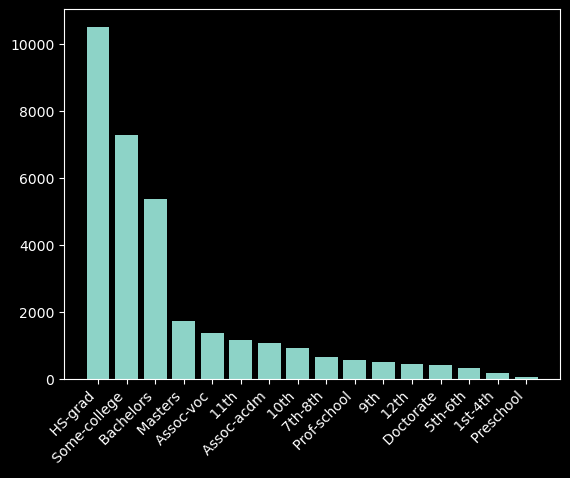

In [70]:
chart = df["education"].value_counts()

plt.xticks(rotation=45,ha="right")
plt.style.use('dark_background')
plt.bar(chart.keys(),chart.values)
